# Bollinger Band Optimisation

This notebook optimises a simple Bollinger Bands trading strategy using Optuna Bayesian Optimisation. 

We aim to maximise either the median or mean Sharpe Ratio or Cumulative Return over multiple 'days' using tick data from the IMC Prosperity Challenge. We have 10,000 ticks per 'day'.

Primary tuning parameters are: Rolling window length (lookback), Z-score threshold, and Max volume per tick.

In [49]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.interpolate import griddata
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

These are the only parameters you need to change in this notebook. Be careful that they are all correct.

In [ ]:
round_num = 3
product = "VOLCANIC_ROCK" # What product is the strategy trading
optimiser_days = [0,1,2] # The days you wish to optimise over for the mean/median sharpe/cumulative return 
max_position = 400 # Must enter value; 400 is max position for volcanic rocks
stop_loss = 1 # 100% (ie. no stop loss currently)
take_profit = 1 # 100% (ie. exit position at 2x)

optimisation_config = {
    "lookback_min": 50,
    "lookback_max": 800,
    "lookback_step": 1,
    "z_thresh_min": 0.3,
    "z_thresh_max": 4,
    "z_thresh_step": 0.05,
    "max_volume_per_tick_min": 1,
    "max_volume_per_tick_max": max_position + 1,
    "max_volume_per_tick_step": 5,
    "num_bayesian_trials": 500,
    "optimise_for": "return",  # can be "return" or "sharpe" (that are optimised for over the optimisation periods)
    "optimise_with": "mean"    # can be "mean" or "median" (of sharpe/cumulative return over the optimisation periods)
}  

Loan and clean data for selected round, instrument, and days from csv files provided by prosperity.

In [ ]:
# --- Load Price Data ---

# Build file paths and load the DataFrames
full_price_df = (
    pd.concat(
        [pd.read_csv(f"prices_round_{round_num}_day_{day}.csv", sep=';') for day in optimiser_days],
        ignore_index=True
    )
    .query('product == @product')  # filter directly
    .assign(time=lambda df: df["day"] * 1000000 + df["timestamp"])  # create time column
    .set_index("time")  # set the index
)

# Display the first few rows
full_price_df.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
time,,,,,,,,,,,,,,,,,
2999500,2,999500,VOLCANIC_ROCK,10167.0,110.0,10166.0,51.0,NaN,NaN,10169,156,NaN,NaN,NaN,NaN,10168.0,0.0
2999600,2,999600,VOLCANIC_ROCK,10166.0,161.0,NaN,NaN,NaN,NaN,10168,101,10169.0,60.0,NaN,NaN,10167.0,0.0
2999700,2,999700,VOLCANIC_ROCK,10166.0,143.0,10165.0,51.0,NaN,NaN,10168,194,NaN,NaN,NaN,NaN,10167.0,0.0
2999800,2,999800,VOLCANIC_ROCK,10167.0,119.0,10166.0,57.0,NaN,NaN,10168,119,10169.0,57.0,NaN,NaN,10167.5,0.0
2999900,2,999900,VOLCANIC_ROCK,10166.0,137.0,10165.0,75.0,NaN,NaN,10167,137,10168.0,75.0,NaN,NaN,10166.5,0.0


Backtesting function - called by other functions later.

In [ ]:
# --- Simulate the bollinger strategy ---
# Entry signals occur when the price crosses upper or lower thresholds.
# Exit occurs via stop-loss / take-profit rules or reversal signals.

def threshold_bid_ask_strategy(df, lookback, z_entry_threshold, day, max_volume_per_tick, 
                                max_position, stop_loss, take_profit, fee_per_unit=0):
   

    must_reverse = False
    last_stopped_side = None

    df = df[df["day"] == day].copy()
    test_size = int(len(df) * 1)
    df = df.iloc[:test_size].copy()

    df['ma'] = df['mid_price'].rolling(window=lookback).mean()
    df['std'] = df['mid_price'].rolling(window=lookback).std()
    df['upper_threshold'] = df['ma'] + z_entry_threshold * df['std']
    df['lower_threshold'] = df['ma'] - z_entry_threshold * df['std']

    initial_cash = 100_000
    cash = initial_cash
    position = 0
    entry_price = None
    entry_time = None

    equity_curve = []
    positions = []
    trades = []

    for i in range(lookback + 1, len(df)):
        row = df.iloc[i]
        mid_price = row['mid_price']
        ma = row['ma']
        upper = row['upper_threshold']
        lower = row['lower_threshold']
        timestamp = row['timestamp']

        bids = [(row.get(f"bid_price_{lvl}"), row.get(f"bid_volume_{lvl}")) for lvl in range(1, 4)]
        asks = [(row.get(f"ask_price_{lvl}"), row.get(f"ask_volume_{lvl}")) for lvl in range(1, 4)]

        bids = [(p, v) for p, v in bids if pd.notna(p) and pd.notna(v)]
        asks = [(p, v) for p, v in asks if pd.notna(p) and pd.notna(v)]

        if not bids or not asks:
            equity_curve.append(cash + position * mid_price)
            positions.append(position)
            continue

        bid_price, bid_volume = max(bids, key=lambda x: x[0])
        ask_price, ask_volume = min(asks, key=lambda x: x[0])

        action = None
        exit_trade = False
        qty_traded = 0

        # Check for SL/TP if position is open
        if position != 0 and entry_price is not None:
            if position > 0:
                sl_price = entry_price * (1 - stop_loss)
                tp_price = entry_price * (1 + take_profit)
                if bid_price <= sl_price or bid_price >= tp_price:
                    last_stopped_side = 'long'
                    must_reverse = True

                    qty = position
                    revenue = qty * bid_price - fee_per_unit * qty
                    cash += revenue
                    trades.append({
                        'exit_index': df.index[i],
                        'exit_time': timestamp,
                        'exit_price': bid_price,
                        'qty': qty,
                        'entry_price': entry_price,
                        'entry_time': entry_time,
                        'action': 'SELL (TP/SL)',
                        'duration': i - entry_time
                    })
                    position = 0
                    entry_price = None
                    entry_time = None
                    exit_trade = True

            elif position < 0:
                sl_price = entry_price * (1 + stop_loss)
                tp_price = entry_price * (1 - take_profit)
                if ask_price >= sl_price or ask_price <= tp_price:
                    last_stopped_side = 'short'
                    must_reverse = True

                    qty = -position
                    cost = qty * ask_price + fee_per_unit * qty
                    cash -= cost
                    trades.append({
                        'exit_index': df.index[i],
                        'exit_time': timestamp,
                        'exit_price': ask_price,
                        'qty': qty,
                        'entry_price': entry_price,
                        'entry_time': entry_time,
                        'action': 'BUY (TP/SL)',
                        'duration': i - entry_time
                    })
                    position = 0
                    entry_price = None
                    entry_time = None
                    exit_trade = True

        # Entry signals only if no active trade
        if not exit_trade:
            

            if ask_price < lower and position < max_position:
                if must_reverse and last_stopped_side == 'long':
                    equity_curve.append(cash + position * mid_price)
                    positions.append(position)
                    continue

                qty = min(max_position - position, ask_volume, max_volume_per_tick)

                
                if qty > 0:
                    cost = qty * ask_price + fee_per_unit * qty
                    cash -= cost
                    position += qty
                    entry_price = ask_price
                    entry_time = i
                    trades.append({
                        'entry_index': df.index[i],
                        'entry_time': timestamp,
                        'entry_price': ask_price,
                        'qty': qty,
                        'action': 'BUY'
                    })
                    must_reverse = False
                    last_stopped_side = None


            elif bid_price > upper and position > -max_position:
                if must_reverse and last_stopped_side == 'short':
                    equity_curve.append(cash + position * mid_price)
                    positions.append(position)
                    continue
                
                qty = min(max_position + position, bid_volume, max_volume_per_tick)

                if qty > 0:
                    revenue = qty * bid_price - fee_per_unit * qty
                    cash += revenue
                    position -= qty
                    entry_price = bid_price
                    entry_time = i
                    trades.append({
                        'entry_index': df.index[i],
                        'entry_time': timestamp,
                        'entry_price': bid_price,
                        'qty': qty,
                        'action': 'SELL'
                    })
                    must_reverse = False
                    last_stopped_side = None


        liquidation_price = bid_price if position > 0 else ask_price if position < 0 else mid_price
        total_equity = cash + position * liquidation_price
        equity_curve.append(total_equity)
        positions.append(position)

    df = df.iloc[lookback + 1:].copy()
    df['equity'] = equity_curve
    df['position'] = positions
    df['strategy_cum'] = df['equity'] / initial_cash
    df['buy_hold_cum'] = df['mid_price'] / df['mid_price'].iloc[0]

    trades_df = pd.DataFrame(trades)

    # Add useful plotting columns to final df
    for lvl in range(1, 4):
        df[f'bid_price_{lvl}'] = df[f'bid_price_{lvl}']
        df[f'ask_price_{lvl}'] = df[f'ask_price_{lvl}']

    df['mid_price'] = df['mid_price']
    df['ma'] = df['ma']
    df['upper_threshold'] = df['upper_threshold']
    df['lower_threshold'] = df['lower_threshold']
    df['current_position'] = df['position']

    return df, trades_df

Hyperparameter optimiser using Optuna Bayesian Optimisation.

In [ ]:
# --- Defines how Optuna will sample parameters and evaluate them ---
# Samples lookback, z-threshold, and max_volume_per_tick.
# Objective: maximise either mean/median Sharpe or mean/median cumulative return.

import warnings
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

def objective(trial, full_price_df, optimiser_days, max_position, stop_loss, take_profit, **optimisation_config):
    
    lookback_min = optimisation_config["lookback_min"]
    lookback_max = optimisation_config["lookback_max"]
    lookback_step = optimisation_config["lookback_step"]
    z_thresh_min = optimisation_config["z_thresh_min"]
    z_thresh_max = optimisation_config["z_thresh_max"]
    z_thresh_step = optimisation_config["z_thresh_step"]
    max_volume_per_tick_min = optimisation_config["max_volume_per_tick_min"]
    max_volume_per_tick_max = optimisation_config["max_volume_per_tick_max"]
    max_volume_per_tick_step = optimisation_config["max_volume_per_tick_step"]
    optimise_for = optimisation_config["optimise_for"]
    optimise_with = optimisation_config["optimise_with"]

    # Sampling parameters
    lookback = trial.suggest_categorical("lookback", [int(x) for x in np.arange(lookback_min, lookback_max, lookback_step)])
    z_thresh = trial.suggest_categorical("z_thresh", [round(float(x), 2) for x in np.arange(z_thresh_min, z_thresh_max, z_thresh_step)])
    max_volume_per_tick = trial.suggest_categorical("max_volume_per_tick", [int(x) for x in np.arange(max_volume_per_tick_min, max_volume_per_tick_max, max_volume_per_tick_step)])

    returns = []
    for day in optimiser_days:
        try:
            test_slice = full_price_df[full_price_df['day'] == day].copy()
            ticks_today = len(test_slice)
            periods_per_year = 252 * ticks_today

            if len(test_slice) < lookback + 10:
                continue

            performance_df, _ = threshold_bid_ask_strategy(
                test_slice,
                lookback=lookback,
                z_entry_threshold=z_thresh,
                day=day,
                max_volume_per_tick=max_volume_per_tick,
                max_position=max_position,
                stop_loss=stop_loss,
                take_profit=take_profit
            )

            if len(performance_df) == 0:
                continue

            performance_df['diff_cum_returns'] = performance_df['strategy_cum'].diff().fillna(0)
            strategy_returns = performance_df['diff_cum_returns'].dropna()

            if len(strategy_returns) > 1:
                if optimise_for == "return":
                    returns.append(performance_df['strategy_cum'].iloc[-1])  # Final cumulative return
                elif optimise_for == "sharpe":
                    # Parameters for Sharpe calculation, assuming risk free rate of 0
                    risk_free_rate = 0.0
                    excess_returns = strategy_returns - risk_free_rate

                    mean_excess = excess_returns.mean()
                    std_excess = excess_returns.std()

                    if std_excess == 0:
                        sharpe = 0
                    else:
                        sharpe = np.sqrt(periods_per_year) * mean_excess / std_excess

                    returns.append(sharpe)

        except Exception as e:
            print(f"Error on day={day}: {e}")
            continue

    if returns:
        if optimise_with == "mean":
            return np.mean(returns)
        elif optimise_with == "median":
            return np.median(returns)
        else:
            raise ValueError(f"Invalid optimise_with '{optimise_with}'. Must be 'mean' or 'median'.")
    else:
        return 0

# --- Set up the Optuna TPE Sampler ---
sampler = optuna.samplers.TPESampler(
    n_startup_trials=10,
    multivariate=True,
    group=True,
    seed=42
)

# --- Create and run the study ---
study = optuna.create_study(direction='maximize')

study.optimize(
    lambda trial: objective(
        trial,
        full_price_df=full_price_df,
        optimiser_days=optimiser_days,
        max_position=max_position,
        stop_loss=stop_loss,
        take_profit=take_profit,
        **optimisation_config
    ),
    n_trials=optimisation_config["num_bayesian_trials"],
    show_progress_bar=True
)


# Best trial
print("\nBest parameters found:")
print(study.best_trial.params)
# --- Extract best parameters and save to individual variables --- 
best_params = study.best_trial.params
best_lookback = best_params["lookback"]
best_z_thresh = best_params["z_thresh"]
best_max_volume_per_tick = best_params["max_volume_per_tick"]


# Get all trials as a DataFrame (params already flattened in your version)
df_trials = study.trials_dataframe()

# Find all parameter columns
param_cols = [col for col in df_trials.columns if col.startswith("params_")]

# Include 'value' in the final DataFrame
df_trials_flat = df_trials[["value"] + param_cols].copy()

# Clean column names (remove 'params_' prefix)
df_trials_flat.columns = ["value"] + [col.replace("params_", "") for col in param_cols]

# Sort and view top trials
df_trials_flat = df_trials_flat.sort_values(by="value", ascending=False)

print("\nTop Trials:")
print(df_trials_flat.head(10))

[I 2025-04-29 02:36:55,626] A new study created in memory with name: no-name-f986dd24-df89-46bb-8bc5-728121448d27


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-04-29 02:36:58,563] Trial 0 finished with value: 1.6696733333333331 and parameters: {'lookback': 415, 'z_thresh': 1.0, 'max_volume_per_tick': 400}. Best is trial 0 with value: 1.6696733333333331.
[I 2025-04-29 02:37:01,391] Trial 1 finished with value: 1.5528266666666666 and parameters: {'lookback': 175, 'z_thresh': 2.85, 'max_volume_per_tick': 400}. Best is trial 0 with value: 1.6696733333333331.
[I 2025-04-29 02:37:04,260] Trial 2 finished with value: 1.81965 and parameters: {'lookback': 633, 'z_thresh': 1.7, 'max_volume_per_tick': 400}. Best is trial 2 with value: 1.81965.
[I 2025-04-29 02:37:07,140] Trial 3 finished with value: 1.5834499999999998 and parameters: {'lookback': 157, 'z_thresh': 0.9, 'max_volume_per_tick': 400}. Best is trial 2 with value: 1.81965.
[I 2025-04-29 02:37:10,055] Trial 4 finished with value: 1.7562266666666666 and parameters: {'lookback': 309, 'z_thresh': 3.2, 'max_volume_per_tick': 400}. Best is trial 2 with value: 1.81965.
[I 2025-04-29 02:37:12,

Fit a polynomial regression surface plot to the optimisation results to visualise the optimisation variable under different combinations of z-score threshold and lookback window, all at the optimum Max Volume per Tick. Currently set to 3rd degree so as not to fit to all the noise, but this can be altered.

Using max_volume_per_tick = 400 for surface plot.
Filtered to 500 trials.
R² score for degree 5 fit: 0.7119


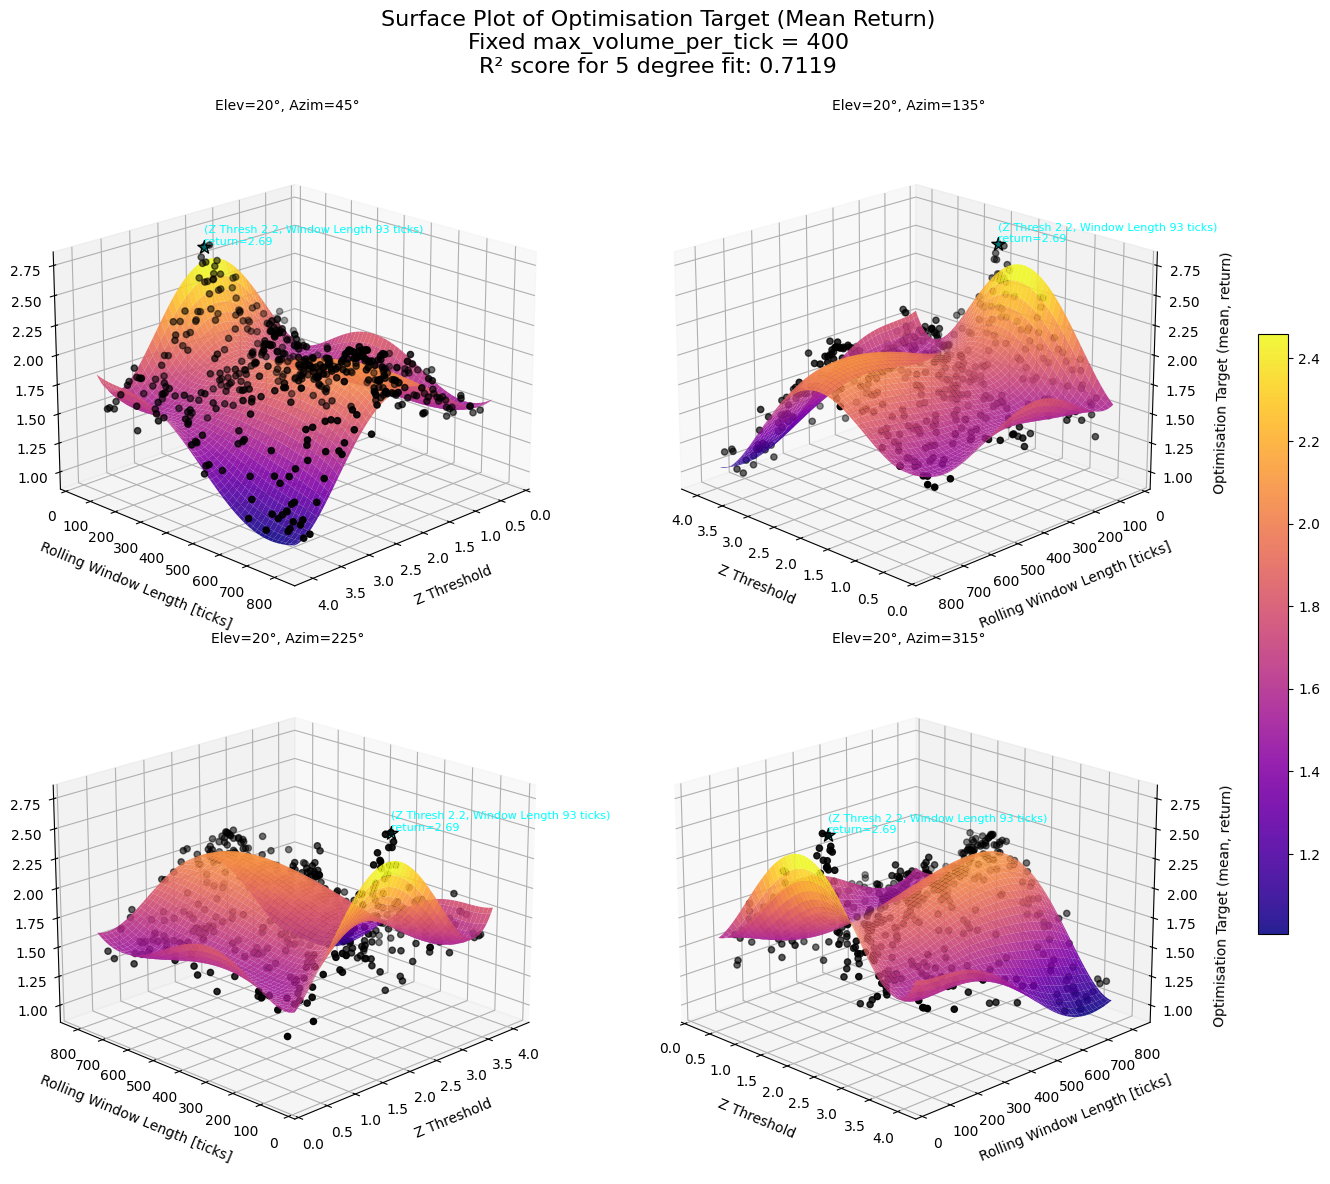

In [55]:
# --- Plot interpolation surface of optimisation values ---
# X = Z Threshold
# Y = Rolling Window Length
# Z = Optimisation Target (Sharpe / Return)

# Fit a polynomial surface to interpolate sparse trial results.
# Plot 4 different 3D views of the surface.

# Set degree for polynomial fit
degree = 5

# --- 1. Pick a fixed max_volume_per_tick to filter ---
filtered_df = df_trials_flat[df_trials_flat['max_volume_per_tick'] == best_max_volume_per_tick]

print(f"Using max_volume_per_tick = {best_max_volume_per_tick} for surface plot.")
print(f"Filtered to {len(filtered_df)} trials.")

# --- 2. Pivot table ---
pivot_table = filtered_df.pivot_table(index='lookback', columns='z_thresh', values='value', aggfunc='mean')

# --- 3. Prepare raw points ---
lookback_vals = pivot_table.index.values
z_thresh_vals = pivot_table.columns.values
X_raw, Y_raw = np.meshgrid(z_thresh_vals, lookback_vals)
Z_raw = pivot_table.values

X_pts = X_raw.flatten()
Y_pts = Y_raw.flatten()
Z_pts = Z_raw.flatten()

valid_mask = ~np.isnan(Z_pts)
X_valid = X_pts[valid_mask]
Y_valid = Y_pts[valid_mask]
Z_valid = Z_pts[valid_mask]

# --- 4. Create fine grid ---
expand_ratio = 0  # 0% expansion of surface

x_min, x_max = X_valid.min(), X_valid.max()
y_min, y_max = Y_valid.min(), Y_valid.max()

xi = np.linspace(x_min - (x_max - x_min) * expand_ratio, x_max + (x_max - x_min) * expand_ratio, 100)
yi = np.linspace(y_min - (y_max - y_min) * expand_ratio, y_max + (y_max - y_min) * expand_ratio, 100)

Xi, Yi = np.meshgrid(xi, yi)

# --- 5. Fit a polynomial surface ---
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(np.column_stack((X_valid, Y_valid)))

model = LinearRegression()
model.fit(X_poly, Z_valid)

# --- Calculate R² score
r2_score = model.score(X_poly, Z_valid)
print(f"R² score for degree {degree} fit: {r2_score:.4f}")

grid_points = np.column_stack((Xi.flatten(), Yi.flatten()))
grid_poly = poly.transform(grid_points)
Z_fit = model.predict(grid_poly)
Z_fit = Z_fit.reshape(Xi.shape)

# Create a mask to remove extrapolated parts
inside_mask = (
    (Xi >= X_valid.min()) & (Xi <= X_valid.max()) &
    (Yi >= Y_valid.min()) & (Yi <= Y_valid.max())
)

# Mask the outside Z values
Z_fit_masked = np.where(inside_mask, Z_fit, np.nan)

# --- 5.5 Set axis limits with a margin ---
margin_ratio = 0.1  # 10% extra
x_min, x_max = X_valid.min(), X_valid.max()
y_min, y_max = Y_valid.min(), Y_valid.max()
z_min, z_max = Z_valid.min(), Z_valid.max()

x_margin = (x_max - x_min) * margin_ratio
y_margin = (y_max - y_min) * margin_ratio
z_margin = (z_max - z_min) * margin_ratio

x_lim = (x_min - x_margin, x_max + x_margin)
y_lim = (y_min - y_margin, y_max + y_margin)
z_lim = (z_min - z_margin, z_max + z_margin)

# --- 6. Plot 4 views with better layout ---
fig = plt.figure(figsize=(15, 12))
# Add a global title for the whole figure
fig.suptitle(
    f"Surface Plot of Optimisation Target ({optimisation_config['optimise_with'].capitalize()} {optimisation_config['optimise_for'].capitalize()})\n"
    f"Fixed max_volume_per_tick = {best_max_volume_per_tick}\n"
    f"R² score for {degree} degree fit: {r2_score:.4f}",
    fontsize=16,
    y=1.02  # moves the title slightly above the top of the figure
)

# Define 4 views
views = [
    (20, 45),
    (20, 135),
    (20, 225),
    (20, 315)
]

axes = []
for idx, (elev, azim) in enumerate(views):
    
    ax = fig.add_subplot(2, 2, idx+1, projection='3d')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)

    axes.append(ax)

    surf = ax.plot_surface(Xi, Yi, Z_fit_masked, cmap='plasma', edgecolor='none', alpha=0.9)

    ax.scatter(X_valid, Y_valid, Z_valid, color='black', s=20)

    # Highlight the optimal parameter point
    best_value = study.best_trial.value 
    ax.scatter(best_z_thresh, best_lookback, best_value, color='cyan', s=100, edgecolor='black', marker='*', label='Optimal Point')

    # Annotate the point with its values
    ax.text(
        best_z_thresh, best_lookback, best_value,
        f'(Z Thresh {best_z_thresh}, Window Length {best_lookback} ticks)\n{optimisation_config["optimise_for"]}={best_value:.2f}',
        color='cyan',
        fontsize=8,
        ha='left',
        va='bottom'
    )

    ax.set_xlabel('Z Threshold', labelpad=8)
    ax.set_ylabel('Rolling Window Length [ticks]', labelpad=8)
    ax.set_zlabel(f'Optimisation Target ({optimisation_config["optimise_with"]}, {optimisation_config["optimise_for"]})', labelpad=8)


    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f'Elev={elev}°, Azim={azim}°', fontsize=10)

# Adjust subplot positions tighter
plt.subplots_adjust(left=0.05, right=0.87, top=0.93, bottom=0.05, wspace=0.02, hspace=0.02)

# Add colorbar outside all plots
cbar_ax = fig.add_axes([0.90, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
fig.colorbar(surf, cax=cbar_ax)

plt.show()

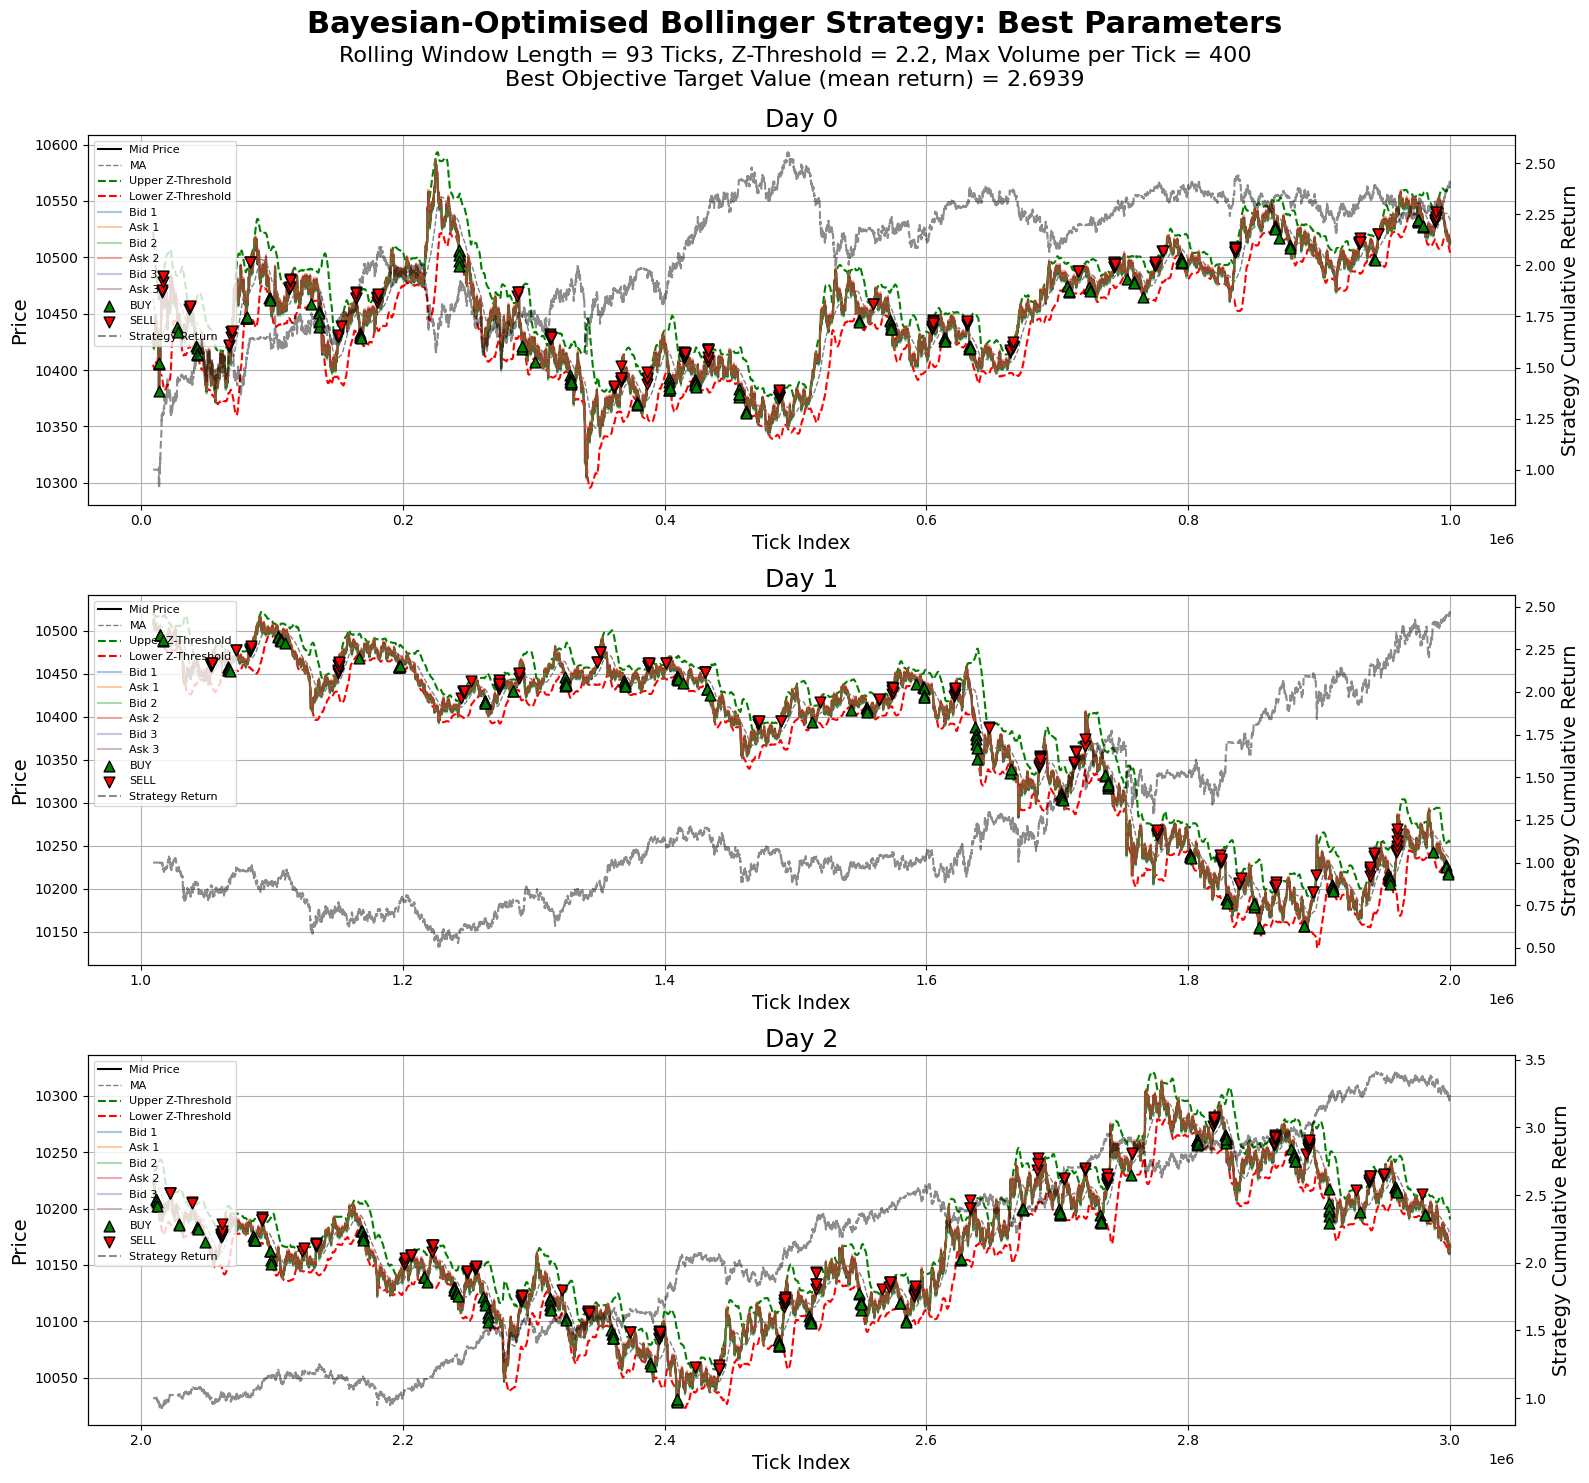

In [56]:
# --- For each day, plot mid price, moving average, thresholds, and trade markers ---
# Each day's chart appears in a vertically stacked layout.

# Mid-price and thresholds on left axis.
# Strategy cumulative returns on right axis.

def plot_full_market_chart(df, ax1):
    # Plot mid price and thresholds
    ax1.plot(df.index, df['mid_price'], label='Mid Price', color='black', linewidth=1.5)
    ax1.plot(df.index, df['ma'], label='MA', linestyle='--', color='gray', linewidth=1)
    ax1.plot(df.index, df['upper_threshold'], label='Upper Z-Threshold', linestyle='--', color='green')
    ax1.plot(df.index, df['lower_threshold'], label='Lower Z-Threshold', linestyle='--', color='red')

    # Bid/Ask levels
    for lvl in range(1, 4):
        bid_col = f'bid_price_{lvl}'
        ask_col = f'ask_price_{lvl}'
        if bid_col in df.columns:
            ax1.plot(df.index, df[bid_col], label=f'Bid {lvl}', linestyle='-', alpha=0.4)
        if ask_col in df.columns:
            ax1.plot(df.index, df[ask_col], label=f'Ask {lvl}', linestyle='-', alpha=0.4)

    # Trades
    if 'trade_action' in df.columns:
        buys = df[df['trade_action'].str.contains('BUY', na=False)]
        sells = df[df['trade_action'].str.contains('SELL', na=False)]

        ax1.scatter(buys.index, buys['mid_price'], color='green', marker='^', s=60,
                    edgecolors='black', zorder=10, label='BUY')
        ax1.scatter(sells.index, sells['mid_price'], color='red', marker='v', s=60,
                    edgecolors='black', zorder=10, label='SELL')

    ax1.set_xlabel("Tick Index", fontsize=14)
    ax1.set_ylabel("Price", fontsize=14)
    ax1.grid(True)

    # Strategy cumulative return on secondary axis
    ax2 = ax1.twinx()
    if 'strategy_cum' in df.columns:
        ax2.plot(df.index, df['strategy_cum'], color='black', linewidth=1.5, linestyle='--', alpha=0.45, label='Strategy Return')
        ax2.set_ylabel("Strategy Cumulative Return", color='black', fontsize=14)
        ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends
    lines_labels_1 = ax1.get_legend_handles_labels()
    lines_labels_2 = ax2.get_legend_handles_labels()
    lines = lines_labels_1[0] + lines_labels_2[0]
    labels = lines_labels_1[1] + lines_labels_2[1]
    ax1.legend(lines, labels, loc='upper left', fontsize=8)

# --- Multi-day plotting block: One chart per row for full width ---

n_days = len(optimiser_days)
fig, axes = plt.subplots(n_days, 1, figsize=(16, 5 * n_days), sharex=False)

# Make sure axes is always iterable
if n_days == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, day in enumerate(optimiser_days):
    ax = axes[idx]

    # Backtest
    performance_df, trades_df = threshold_bid_ask_strategy(
        full_price_df, best_lookback, best_z_thresh,
        day, best_max_volume_per_tick, max_position,
        stop_loss, take_profit
    )

    combined_df = performance_df.copy()

    if not trades_df.empty:
        trades_df = trades_df.set_index('entry_index')
        trades_info = trades_df[['action', 'qty', 'entry_price']].rename(columns={
            'action': 'trade_action',
            'qty': 'trade_qty',
            'entry_price': 'trade_price'
        })
        combined_df = combined_df.join(trades_info, how='left')

    # Plot into the subplot
    plot_full_market_chart(combined_df, ax)
    ax.set_title(f"Day {day}", fontsize=18)

# --- First, main bold title ---
fig.text(
    0.5, 0.97,  # x=center, y=high up
    "Bayesian-Optimised Bollinger Strategy: Best Parameters",
    fontsize=22, fontweight='bold', ha='center'
)

# --- Then, smaller parameter details ---
fig.text(
    0.5, 0.935,  # slightly below the first title
    f"Rolling Window Length = {best_lookback} Ticks, Z-Threshold = {best_z_thresh}, "
    f"Max Volume per Tick = {best_max_volume_per_tick}\n"
    f"Best Objective Target Value ({optimisation_config['optimise_with']} {optimisation_config['optimise_for']}) = {study.best_value:.4f}",
    fontsize=16, ha='center'
)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Reserve space for titles
plt.show()